In [1]:
import re
import ast
import emot
import nltk
import string
import pycountry
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/hosseinhimself/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hosseinhimself/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def replace_emoji(text):
    emot_obj = emot.core.emot()
    emotes = emot_obj.emoji(text)
    for i in range(len(emotes['value'])):
        text = text.replace(emotes['value'][i], emotes['mean'][i])
    return text


def normalize(text):
    link_pattern = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    text = re.sub(link_pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = replace_emoji(text)
    text = text.replace('\n',' ')
    return text


In [14]:
data = pd.read_csv("datamissingbaby.csv")
pd.set_option('float_format', '{:.0f}'.format)

tweets = data['text']

In [15]:
data.head()

,Unnamed: 0,tweetID,username,description,location,following,followers,totaltweets,retweetcount,tweetdate,likes,link,IDreplyTo,text,hashtags
0,0,1634665979585380352,abt_live,"ABT LIVE covers breaking news, and the latest ...",India,10,767,69814,0,2023-03-11 21:21:54+00:00,0,https://twitter.com/i/web/status/1634665979585...,NaN,Constance Marten: Dead baby called Victoria fo...,"['eastsussex', 'brighton', 'metropolitanpolice..."
1,1,1634463934710177792,ATGBrokers,"ATGBrokers Group,\n( Founder/Owner )\n\nBreaki...",on Earth!,260,132,626868,0,2023-03-11 07:59:03+00:00,0,https://twitter.com/i/web/status/1634463934710...,NaN,News (Baby's body found in plastic bag in shed...,[]
2,2,1634386605480738816,Jane__8805,Ноrnу wоman 💥😼💐,NaN,176,2,316,1,2023-03-11 02:51:46+00:00,0,https://twitter.com/i/web/status/1634386605480...,NaN,"Absolutely heartbreaking, RIP bubba 💔💔 #consta...",['constancemartin']
3,3,1634157693530173440,gerrard7281,I will always love football ⚽️,United Kingdom,58,303,267,54,2023-03-10 11:42:09+00:00,241,https://twitter.com/i/web/status/1634157693530...,NaN,"""We believe sadly the baby may have been dead ...",[]
4,4,1634157676849405952,gerrard7281,I will always love football ⚽️,United Kingdom,58,303,267,88,2023-03-10 11:42:05+00:00,550,https://twitter.com/i/web/status/1634157676849...,NaN,Constance Marten and Mark Gordon charged with ...,[]


In [6]:
print(f'{len(data.index)} tweets about missing baby news.')

12849 tweets about missing baby news.


In [7]:
analyzer = SentimentIntensityAnalyzer()

# Define a dictionary to map the sentiment scores to emotions
emotion_dict = {'angry':0,
               'upset': 0,
               'netural':0,
               'curious':0,
               'happy':0}

all_scores = []

# Loop through each tweet and determine the emotion
for tweet in tweets:
    # Get the sentiment score for the tweet
    sentiment_score = analyzer.polarity_scores(normalize(tweet))
    all_scores.append(sentiment_score)
    # Determine the emotion based on the sentiment score
    
    if sentiment_score['neg'] > sentiment_score['pos']:
        if sentiment_score['neg'] > sentiment_score['neu']:
            emotion_dict['angry'] += 1
        else:
            emotion_dict['upset'] += 1
            
            
    elif sentiment_score['pos'] > sentiment_score['neg']:
        if sentiment_score['pos'] > sentiment_score['neu']:
            emotion_dict['happy'] += 1
        else:
            emotion_dict['curious'] += 1
            
            
    else:
        if sentiment_score['neu'] > 0.5:
            emotion_dict['netural'] += 1

In [8]:
# Print the count of each emotion
for emotion, count in emotion_dict.items():
    print(f"{emotion}: {count}")

angry: 147
upset: 9355
netural: 1678
curious: 1650
happy: 19


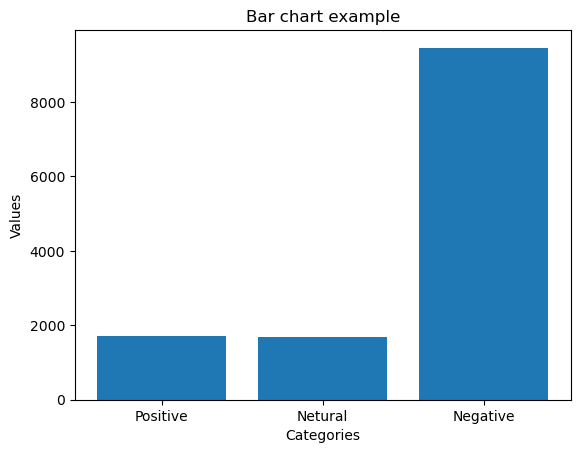

In [9]:
compound_scores = []
for tweet_scores in all_scores:
    compound_scores.append(tweet_scores['compound'])
    
scores = np.array(compound_scores)

x = np.array(['Positive', 'Netural', 'Negative'])
y = np.array([np.sum(scores > 0), np.sum(scores == 0), np.sum(scores < 0)])

# Create bar chart
plt.bar(x, y)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar chart example')

# Show chart
plt.show()

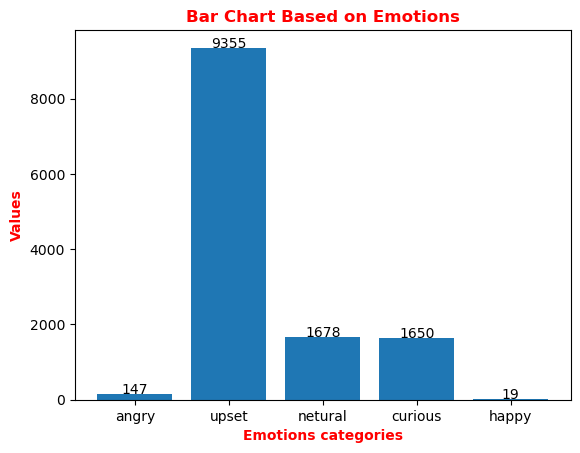

In [10]:
compound_scores = []
for tweet_scores in all_scores:
    compound_scores.append(tweet_scores['compound'])
    
scores = np.array(compound_scores)

x = np.array([emotion for emotion in emotion_dict.keys()])
y = np.array([emotion[1] for emotion in emotion_dict.items()])

# Create bar chart
plt.bar(x, y)

# Write the number of each bar above it
for i, v in enumerate(y):
    plt.text(i, v + 0.2, str(v), ha='center')

# Add labels and title
plt.xlabel('Emotions categories', fontweight="bold", color="red")
plt.ylabel('Values', fontweight="bold", color="red")
plt.title('Bar Chart Based on Emotions', fontweight="bold", color="red")

# Show chart
plt.show()


In [11]:
STOP_WORDS = stopwords.words()

# removing the emojies
# https://www.kaggle.com/alankritamishra/covid-19-tweet-sentiment-analysis#Sentiment-analysis
EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)


def cleaning(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    text = EMOJI_PATTERN.sub(r'', text)

    # removing the stop-words
    text_tokens = word_tokenize(text)
    tokens_without_sw = [
        word for word in text_tokens if not word in STOP_WORDS]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence

    return text

max_rows = 1000

dt = data['text'].apply(cleaning)

word_count = Counter(" ".join(dt).split()).most_common(10)
word_frequency = pd.DataFrame(word_count, columns = ['tag word', 'Frequency'])
print('tags frequency:')
word_frequency

tags frequency:


,tag word,Frequency
0,constance,11155
1,marten,9759
2,baby,9391
3,mark,7426
4,gordon,6945
5,found,4869
6,police,4703
7,missing,3579
8,search,2891
9,arrested,2819


In [12]:
data.sort_values(by='followers', ascending=False)[['username', 'followers']].drop_duplicates(subset='username').head(20)

,username,followers
7066,cnnbrk,64195142
7116,CNN,61267702
2868,BBCBreaking,51687011
1042,BBCWorld,39627731
2901,BBCNews,15068897
7114,cnni,14473199
11026,HuffPost,11204819
2763,guardian,10898010
11188,CBSNews,8918937
2871,SkyNews,8375913


In [13]:
locations = data.drop_duplicates(subset='username')['location']

processed_locations = []
for location in locations:
    if type(location) == str:
        location = location.split(', ')
        processed_locations.append(location)
        
country_counter = {}

# get all countries
all_countries = list(pycountry.countries)


for country in all_countries:
    country_counter[country.name] = 0

else:
    country_counter['Unknown'] = 0
    

for country in all_countries:
    for item in processed_locations:
        if country.name in item:
            country_counter[country.name] += 1
        elif country.alpha_2 in item:
            country_counter[country.name] += 1
        elif country.alpha_3 in item:
            country_counter[country.name] += 1
        elif country.flag in item:
            country_counter[country.name] += 1
            
sorted_countries = dict(sorted(country_counter.items(), key=lambda x: x[1], reverse=True))



In [14]:
dict_for_drawing_chart = {}

# set the threshold value
threshold = 10

for country in sorted_countries.items():
    if country[1] > threshold:
        dict_for_drawing_chart[country[0]] = country[1]


# sum the values less than the threshold
total = sum(value for value in sorted_countries.values() if value < threshold)

dict_for_drawing_chart['Others'] = total

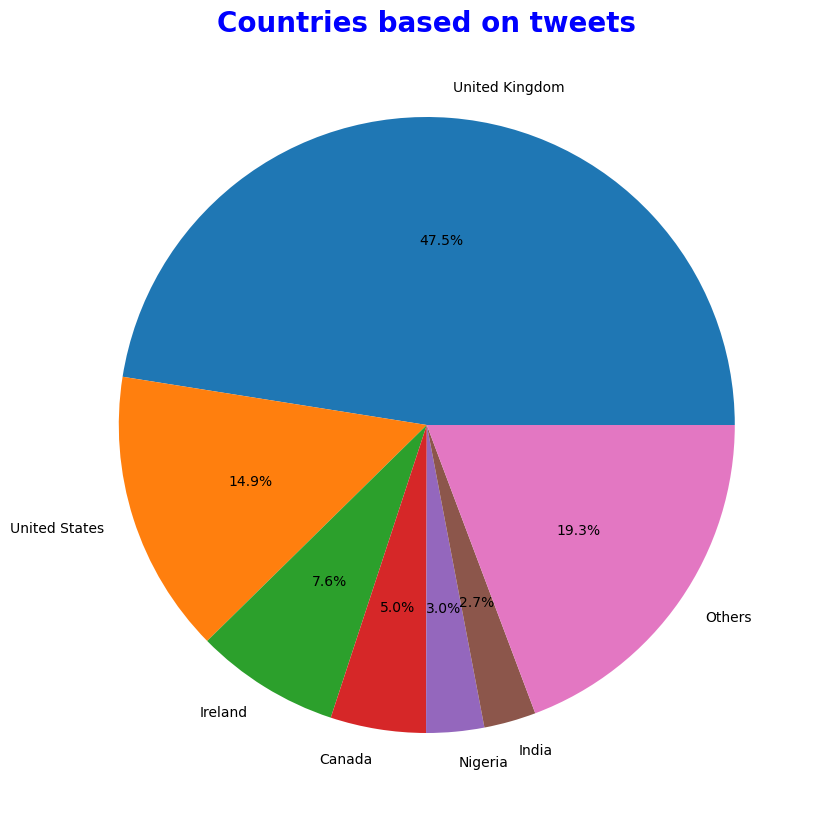

In [15]:
import math
# data for the pie chart


summation = sum(value for value in dict_for_drawing_chart.values())





labels = np.array([country[0] for country in dict_for_drawing_chart.items()])

sizes = np.array([country[1] for country in dict_for_drawing_chart.items()])



# Create a pie chart
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.title('Countries based on tweets', fontweight="bold", color="blue", fontsize=20)

# display the chart
plt.show()

In [16]:
locations = data.drop_duplicates(subset='username')['location']

processed_locations = []
for location in locations:
    if type(location) == str:
        location = location.split(', ')
        processed_locations.append(location)
        
country_counter = {}

# get all countries
all_countries = list(pycountry.countries)


for country in all_countries:
    if country.name == 'United Kingdom':
        GB = country
        
GB_tweets = []
        
for item in processed_locations:
    if GB.name in item:
        GB_tweets.append(item)
    elif GB.alpha_2 in item:
        GB_tweets.append(item)
    elif GB.alpha_3 in item:
        GB_tweets.append(item)
    elif GB.flag in item:
        GB_tweets.append(item)
        


In [17]:
GB_names = [GB.name, GB.alpha_2, GB.alpha_3, GB.flag]
unknown_city = 0
cities ={}
for items in GB_tweets:
    for item in items:
        if item in GB_names:
            items.remove(item)
        if len(items) == 0:
            unknown_city += 1
        else:
            if items[0] in cities.keys():
                cities[items[0]] += 1
            else:
                cities[items[0]] = 1
                


In [18]:
cities = dict(sorted(cities.items(), key=lambda x: x[1], reverse=True))
cities['Unknown'] = unknown_city
cities

{'England': 228,
 'Scotland': 46,
 'Wales': 24,
 'London': 12,
 'Northern Ireland': 4,
 'East Kilbride': 2,
 'Belfast': 2,
 'Surrey': 2,
 'Southsea': 2,
 'Manchester': 2,
 'Northampton': 2,
 'Derbyshire': 2,
 'Salford': 2,
 'Kent,England': 2,
 'West Sussex': 2,
 'Oxford': 2,
 'Africa': 1,
 'Hertfordshire': 1,
 'Unknown': 143}

In [26]:
pd.set_option('float_format', '{:.0f}'.format)

print('Sort By retweets:')
sort_retweets = data.sort_values(by='tweetdate')[['username', 'text','retweetcount','link']].drop_duplicates(subset='text')
sort_retweets = sort_retweets.sort_values(by='retweetcount', ascending=False).head(10)

for i in (sort_retweets['link']):
    print(i)

sort_retweets


Sort By retweets:
https://twitter.com/i/web/status/1631262898973560835
https://twitter.com/i/web/status/1631261214935330816
https://twitter.com/i/web/status/1631319333757657091
https://twitter.com/i/web/status/1631749019327234054
https://twitter.com/i/web/status/1630941889460305921
https://twitter.com/i/web/status/1631379997796474887
https://twitter.com/i/web/status/1631680877234212864
https://twitter.com/i/web/status/1631746427738095634
https://twitter.com/i/web/status/1631093684224630784
https://twitter.com/i/web/status/1631306626228449288


,username,text,retweetcount,link
3073,jeromethegnome,The media assumes that privileged aristocrats ...,329,https://twitter.com/i/web/status/1631262898973...
3075,zeegunner1,Baby's body found by UK police searching for m...,243,https://twitter.com/i/web/status/1631261214935...
2701,gj1023,BREAKING: Police have found the remains of a b...,178,https://twitter.com/i/web/status/1631319333757...
640,Meyawos,Constance Marten and Mark Gordon arrested on s...,96,https://twitter.com/i/web/status/1631749019327...
9135,SuperNi91485714,Constance Marten and Mark Gordon further arres...,90,https://twitter.com/i/web/status/1630941889460...
2290,BBCBreaking,Constance Marten and Mark Gordon charged with ...,88,https://twitter.com/i/web/status/1631379997796...
1044,BBCBreaking,Couple Constance Marten and Mark Gordon appear...,88,https://twitter.com/i/web/status/1631680877234...
3630,moonLilsxx,If you think the arrest of Mark Gordon &amp; C...,83,https://twitter.com/i/web/status/1631746427738...
6707,soniadyne,Update : Constance Marten &amp; Mark Gordon re...,78,https://twitter.com/i/web/status/1631093684224...
2905,BBCBreaking,Police questioning Constance Marten and Mark G...,71,https://twitter.com/i/web/status/1631306626228...


In [27]:
print('Sort By likes:')
sort_likes = data.sort_values(by='tweetdate')[['username', 'text','likes','link']].drop_duplicates(subset='text')
sort_likes = sort_likes.sort_values(by='likes', ascending=False).head(10)
    
for i in (sort_likes['link']):
    print(i)

sort_likes

Sort By likes:
https://twitter.com/i/web/status/1631262898973560835
https://twitter.com/i/web/status/1631261214935330816
https://twitter.com/i/web/status/1631767029706260486
https://twitter.com/i/web/status/1631276490028380161
https://twitter.com/i/web/status/1631379997796474887
https://twitter.com/i/web/status/1631333271077363729
https://twitter.com/i/web/status/1631392387279757324
https://twitter.com/i/web/status/1631680877234212864
https://twitter.com/i/web/status/1631266701042933766
https://twitter.com/i/web/status/1631319333757657091


,username,text,likes,link
3073,jeromethegnome,The media assumes that privileged aristocrats ...,3333,https://twitter.com/i/web/status/1631262898973...
3075,zeegunner1,Baby's body found by UK police searching for m...,877,https://twitter.com/i/web/status/1631261214935...
586,lorrainemking,Constance Marten and Markl Gordon's baby was a...,687,https://twitter.com/i/web/status/1631767029706...
3020,JoshyNewcombe,Constance Marten and Mark Gordon…\nFuck you. F...,598,https://twitter.com/i/web/status/1631276490028...
2290,BBCBreaking,Constance Marten and Mark Gordon charged with ...,550,https://twitter.com/i/web/status/1631379997796...
2584,Adebeyo57442,Bring back the death penalty for Constance Mar...,541,https://twitter.com/i/web/status/1631333271077...
1992,flutterz99,A special place in hell for Mark Gordon and Co...,499,https://twitter.com/i/web/status/1631392387279...
1044,BBCBreaking,Couple Constance Marten and Mark Gordon appear...,455,https://twitter.com/i/web/status/1631680877234...
3063,MollyShep,Not the most diplomatic tweet ever... but fuck...,412,https://twitter.com/i/web/status/1631266701042...
2701,gj1023,BREAKING: Police have found the remains of a b...,365,https://twitter.com/i/web/status/1631319333757...


In [29]:
print('sort by time:')
sort_times = data.sort_values(by='tweetdate')[['username', 'text','tweetdate','link']].drop_duplicates(subset='text').head(10)
    
for i in (sort_times['link']):
    print(i)
    
sort_times


sort by time:
https://twitter.com/i/web/status/1631259472059301889
https://twitter.com/i/web/status/1631260593804935169
https://twitter.com/i/web/status/1631260740966313984
https://twitter.com/i/web/status/1631261112422285312
https://twitter.com/i/web/status/1631261214935330816
https://twitter.com/i/web/status/1631262185560109056
https://twitter.com/i/web/status/1631262898973560835
https://twitter.com/i/web/status/1631264079233908736
https://twitter.com/i/web/status/1631264318435016704
https://twitter.com/i/web/status/1631265521843724289


,username,text,tweetdate,link
3079,EveningStandard,Detectives continue to quiz Constance Marten a...,2023-03-02 11:45:40+00:00,https://twitter.com/i/web/status/1631259472059...
3078,Retrochbabe,Mark Gordon and Constance Marten: remains foun...,2023-03-02 11:50:07+00:00,https://twitter.com/i/web/status/1631260593804...
3077,NewsfeedsMedia,Frantic police search for runaway aristocrat C...,2023-03-02 11:50:42+00:00,https://twitter.com/i/web/status/1631260740966...
3076,gilbmarie,The remains of Constance Marten’s missing baby...,2023-03-02 11:52:11+00:00,https://twitter.com/i/web/status/1631261112422...
3075,zeegunner1,Baby's body found by UK police searching for m...,2023-03-02 11:52:35+00:00,https://twitter.com/i/web/status/1631261214935...
3074,MBooboo26,Why is the headline for this story “Constance ...,2023-03-02 11:56:27+00:00,https://twitter.com/i/web/status/1631262185560...
3073,jeromethegnome,The media assumes that privileged aristocrats ...,2023-03-02 11:59:17+00:00,https://twitter.com/i/web/status/1631262898973...
3071,24trendsAU,11. Thunder vs Lakers - 5K+\n12. Kevin Durant ...,2023-03-02 12:03:58+00:00,https://twitter.com/i/web/status/1631264079233...
3070,kimberleydaph,I met Constance Marten and she appeared to be ...,2023-03-02 12:04:55+00:00,https://twitter.com/i/web/status/1631264318435...
3068,SkyNews,Detectives are continuing to question Constanc...,2023-03-02 12:09:42+00:00,https://twitter.com/i/web/status/1631265521843...


In [34]:
data2 = data.copy()
data2['IDreplyTo']  = data2['IDreplyTo'].astype(str)
data2['tweetID']  = data2['tweetID'].astype(str)
counts = data2.apply(lambda x: x['IDreplyTo'].count(x['tweetID']), axis=1)
data2['counts'] = counts
data2.sort_values(by='counts', ascending=False)[['username', 'text','counts']].head(10)

,username,text,counts
6424,PakWorldNews4,Constance Marten arrest: Remains of baby found...,1
8570,Crazier,May Constance Marten and Mark Gordon never kno...,1
8560,Lucymcdxo,Constance Marten and her evil boyfriend deserv...,1
8561,OkBiology,Police have found the remains of a baby in the...,1
8562,George_Bowling1,🚨 BREAKING Police confirm aristocrat Constance...,1
8563,LufcCharlie2,May the baby rest in peace. Mark Gordon &amp; ...,1
8564,guydixon1,Police confirm aristocrat Constance Marten’s b...,1
8565,RyanTheSoapking,BREAKING: The body of a baby has been found am...,1
8566,HedleyDhedley78,BREAKING: Remains have been found in the searc...,1
8567,krismccaff,Constance Marten and Mark Gordon should be hun...,1
